<a href="https://colab.research.google.com/github/hadzi123/Face_Mask_Classification/blob/main/Face_Mask_Classifciation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 26 kB/s 
     |████████████████████████████████| 462 kB 52.5 MB/s 


In [1]:
!nvidia-smi

Mon Apr 25 11:48:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils

In [3]:
def load_dataset(path):
    data = load_files(path)
    mask_files = np.array(data['filenames'])
    mask_targets = np_utils.to_categorical(np.array(data['target']),4)
    class_names = data['target_names']
    return mask_files, mask_targets, class_names

# load train, test, and validation datasets
train_files, train_targets, class_names = load_dataset('/content/drive/MyDrive/Face Mask 4 classes/Train')
valid_files, valid_targets, _ = load_dataset('/content/drive/MyDrive/Face Mask 4 classes/Validation')
test_files, test_targets, _ = load_dataset('/content/drive/MyDrive/Face Mask 4 classes/Test')

In [4]:
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input

def load_image(path):
  image = cv2.imread(path).astype(np.float32)
  image_resized = cv2.resize(image,(250,250))
  image/=255.0
  image = preprocess_input(image_resized)
  return image

def load_dataset(files):
  for i, file in enumerate(files):
    vector = []
    for file in files:
      vector.append(load_image(file))
    return np.array(vector)


train_X = load_dataset(train_files)
test_X = load_dataset(test_files)
val_test_X = load_dataset(valid_files)

In [6]:
print(train_X.shape)
print(val_test_X.shape)
print(train_targets.shape)
print(valid_targets.shape)

(2354, 250, 250, 3)
(292, 250, 250, 3)
(2354, 4)
(292, 4)


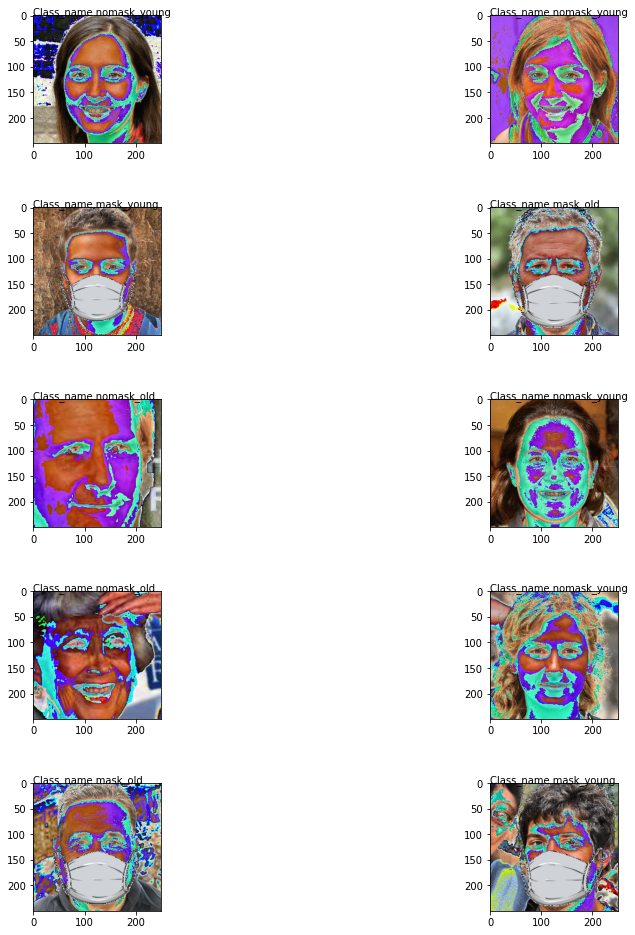

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.5)
rows = 6
columns = 2
for i in range(10):
    ax1 = fig.add_subplot(rows, columns,(i+1))
    ax1.imshow(cv2.cvtColor((train_X[i]*255).astype('uint8'), cv2.COLOR_BGR2RGB ))
    title = ("Class_name "+ class_names[np.argmax(train_targets[i])])
    ax1.text(0, -2, title, size=10)
plt.show()

In [8]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

In [9]:
model = Xception(include_top=False, input_shape=(250,250,3), weights="imagenet")

layer = model.get_layer('block13_pool')

flat = Flatten()(layer.output)
class_ = Dense(1024, activation='relu')(flat)
outputs = Dense(4, activation='softmax')(class_)

model = Model(inputs=model.inputs, outputs = outputs)

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [10]:
import keras
import tensorflow as tf 
from tensorflow import keras

optimizer = keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
#Image augmentation
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
		zoom_range=0.2,
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.2,
		horizontal_flip=True,
		fill_mode="nearest"
        )

datagen.fit(train_X)

#Save best model
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(datagen.flow(train_X, 
                                 train_targets,
                                 batch_size=32),
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(val_test_X, 
                                     valid_targets))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 1.0743 - accuracy: 0.8513
Epoch 1: val_accuracy improved from -inf to 0.75342, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
74/74 [==============================] - 161s 2s/step - loss: 1.0743 - accuracy: 0.8513 - val_loss: 1.1562 - val_accuracy: 0.7534
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9469
Epoch 2: val_accuracy improved from 0.75342 to 0.92466, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
74/74 [==============================] - 140s 2s/step - loss: 0.1624 - accuracy: 0.9469 - val_loss: 0.2520 - val_accuracy: 0.9247
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9571
Epoch 3: val_accuracy improved from 0.92466 to 0.92808, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
74/74 [=========================

In [12]:
from keras.models import load_model
model.load_weights('best_model.pt')

In [13]:
score = model.evaluate(val_test_X, valid_targets)

print('Test accuracy: ', score[1])

10/10 [==============================] - 3s 330ms/step - loss: 0.2455 - accuracy: 0.9555
Test accuracy:  0.9554794430732727


In [14]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names[predicted_class]

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
scores = model.evaluate(test_X, test_targets, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))
y_pred = model.predict(test_X)

Accuracy: 94.30%


In [16]:
print(classification_report(y_pred.round(), test_targets))
accuracy = accuracy_score(test_targets, y_pred.round(), normalize=True)
f1score = f1_score(test_targets, y_pred.round(), average='weighted')

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        65
           1       0.95      0.89      0.92        83
           2       0.95      1.00      0.97        69
           3       1.00      0.95      0.97        81

   micro avg       0.94      0.94      0.94       298
   macro avg       0.94      0.95      0.94       298
weighted avg       0.94      0.94      0.94       298
 samples avg       0.94      0.94      0.94       298



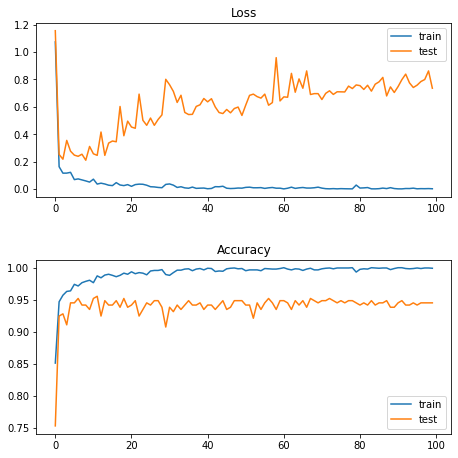

In [17]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,7))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
figure.tight_layout(pad=3.0)
plt.show()

In [61]:
import matplotlib.pyplot as plt
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_preprocessed  = cv2.resize(image, (250,250))
  image_preprocessed = preprocess_input(image_preprocessed)
  return image_preprocessed, image

def predict_url(url):
  image_preprocessed, image = url_to_image(url)
  predicted_class = get_prediction(image_preprocessed)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

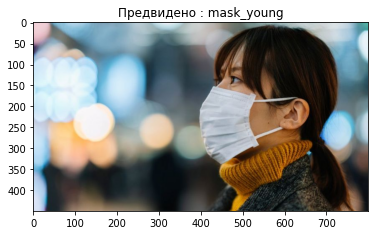

In [19]:
predict_url("https://ichef.bbci.co.uk/news/800/cpsprodpb/E907/production/_110755695_gettyimages-1202072951.jpg")


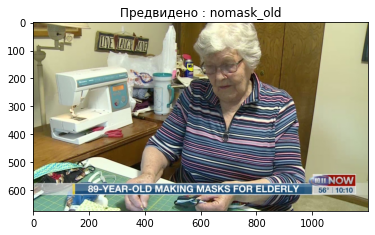

In [20]:
predict_url("https://gray-koln-prod.cdn.arcpublishing.com/resizer/J78VpyO8C969QDLa8cnO3pfeLG8=/1200x675/smart/cloudfront-us-east-1.images.arcpublishing.com/gray/DJ2P5AJ5VRODDDTUBIJMGPJF54.png")


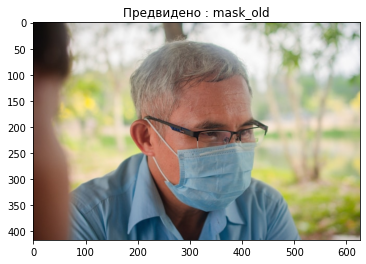

In [21]:
predict_url("https://image.freepik.com/free-photo/old-man-using-face-mask-protect-corona-virus-covid-19-when-communication-with-people_10541-1759.jpg")


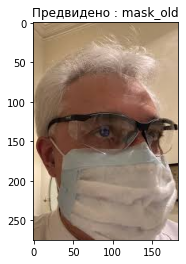

In [23]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRydIoYSikh0xrwUH3zCJ7eJ2NpOFTD3RwL3Q&usqp=CAU")


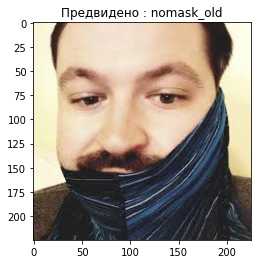

In [25]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRHWmu4DrQdg081nEBO1vsdh_rxU8o9oheXHg&usqp=CAU")


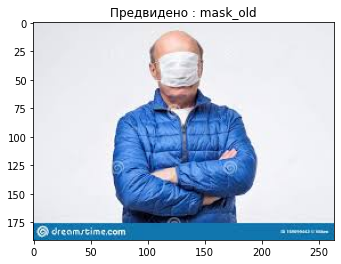

In [26]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRt7p2Fr2Qjm2K44EKaosQQKiP9JQ11__tdfw&usqp=CAU")


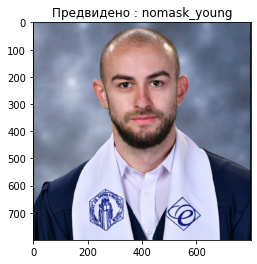

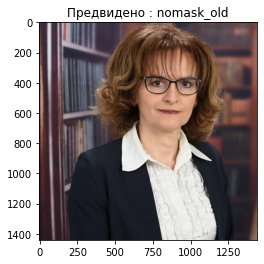

In [64]:
predict_url("https://scontent.fskp4-1.fna.fbcdn.net/v/t1.6435-9/59064647_2704941159522723_6741615177310928896_n.jpg?_nc_cat=104&ccb=1-5&_nc_sid=174925&_nc_ohc=RghmYu0JfK4AX-9W9A3&tn=ZajtTB348S-4oGOD&_nc_ht=scontent.fskp4-1.fna&oh=00_AT85PbnKq-c4TQfvjzfwnvCX-89gWnmqJvu-p7tmgPRaEg&oe=628C777A")


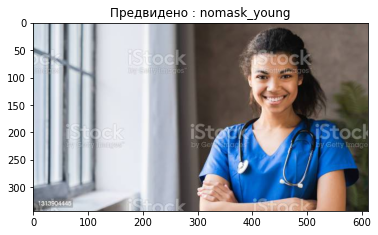

In [65]:
predict_url("https://media.istockphoto.com/photos/portrait-of-africanamerican-female-doctor-with-stethoscope-on-a-picture-id1313904445?s=612x612")

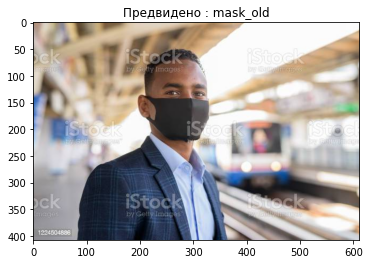

In [71]:
predict_url("https://media.istockphoto.com/photos/young-african-businessman-with-mask-for-protection-from-corona-virus-picture-id1224504886?s=612x612")

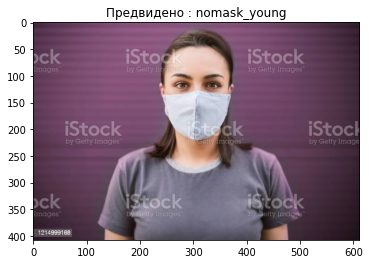

In [77]:
predict_url("https://media.istockphoto.com/photos/beautiful-girl-with-medical-mask-to-protect-her-from-virus-corona-picture-id1214999168?s=612x612")

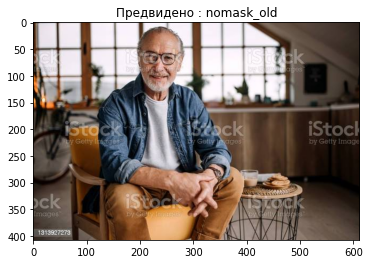

In [82]:
predict_url("https://media.istockphoto.com/photos/portrait-of-senior-man-sitting-in-chair-picture-id1313927273?s=612x612")

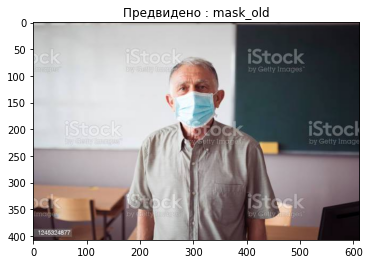

In [87]:
predict_url("https://media.istockphoto.com/photos/portrait-of-senior-teacher-wearing-a-face-mask-during-corona-virus-picture-id1245324877?s=612x612")